## Requirements

### Web-Scraping
#### 1. Take the base wg-gesucht URL and scrape the shared flats listed on the website
#### 2. most important data points are price, room size and number of flat mates

### Data Analyis
#### 1. Correlation analysis of room price and room size. Hypothesis: positive correlation
#### 2. Correlation analysis of room price and number of flat mates. Hypothesis: negative correlation

### Import all neccessary libraries

In [5]:
import requests
import random
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot as plt
from datetime import datetime

In [11]:
data = {'Bewohner': [], 'Eintrag': [], 'Miete': [], 'Groese': [] , 'Stadtteil': [], 'frei ab': [], 'frei bis': []}
df = pd.DataFrame(data=data)
print(df ,len(df))


Empty DataFrame
Columns: [Bewohner, Eintrag, Miete, Groese, Stadtteil, frei ab, frei bis]
Index: [] 0


In [10]:
proxies = [
    'http://24.106.221.230:53281',
    'http://118.70.12.171:53281',
    'http://198.199.86.11:8080',
    'http://107.173.80.140:9000',
    'http://159.203.61.169:8080',
    'http://134.209.29.120:3128',
    'http://192.140.42.83:31511',
    'http://20.187.77.5:80',
    'http://64.225.8.191:9986',
    'http://198.59.191.234:8080',
    'http://51.178.47.12:80',
    'http://82.180.163.163:80',
    'http://158.69.72.138:9300',
    'http://198.49.68.80:80',
    'http://51.15.192.229:8080',
    'http://161.35.70.249:8080',
    'http://143.110.232.177:80',
    'http://154.118.228.212:80',
    'http://177.87.144.122:5566',
    'http://200.25.254.193:54240',
    'http://82.180.163.163:80'
    ]
userAgents = [
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1.1 Safari/605.1.15',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:77.0) Gecko/20100101 Firefox/77.0',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:77.0) Gecko/20100101 Firefox/77.0',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
]

In [8]:
def makeRequest(url):
    try:
        randomNum = random.randint(0, len(proxies) - 1)
        proxy = {proxies[randomNum][0 : 4] : proxies[randomNum]}
        print('Current Proxy: ', proxy)
        
        return requests.get(url,
                            proxies=proxy,
                            headers={'User-Agent' : userAgents[random.randint(0, len(userAgents) -1)]},
                            timeout=5)
    except:
        print("PROBLEM WHILE MAKING REQUEST")

def scrapeTable(tbody) -> None:
    data = []
    rows = tbody.findAll('tr')
    for row in rows:
        data.append(getFlatmates(row))
        data.append(getDatePosted(row))
        data.append(getPrice(row))
        data.append(getRoomSize(row))
        data.append(getNeighborhood(row))
        data.append(getMoveInDate(row))
        data.append(getMoveOutDate(row))
        
        df.loc[len(df)] = data
        data.clear()
    
    print(data)

def getFlatmates(row):
    flatMatesDict = row.findAll('td')[1].span.attrs # returns dictionary
    return flatMatesDict.get('title')

def getDatePosted(row):
    return row.findAll('td')[2].span.text.strip()

def getPrice(row):
    return row.findAll('td')[3].b.text.strip()

def getRoomSize(row):
    return row.findAll('td')[4].span.text.strip()

def getNeighborhood(row):
    return  row.findAll('td')[5].span.text.strip()

def getMoveInDate(row):
    return  row.findAll('td')[6].span.text.strip()

def getMoveOutDate(row):
    date = row.findAll('td')[7].a
    if date.find('span'):
        return date.find('span').text.strip()
    
    return ""

In [12]:
#df.head()
for i in range(0, 20):
    print(f'page: {i}')
    res = makeRequest(f'https://www.wg-gesucht.de/wg-zimmer-in-Mannheim.85.0.0.{i}.html')
    try: 
        page = BeautifulSoup(res.content, 'html.parser')
        scrapeTable(page.findAll('tbody')[0])
    except:
        print("Error")
        break

page: 0
Current Proxy:  {'http': 'http://82.180.163.163:80'}
[]
page: 1
Current Proxy:  {'http': 'http://134.209.29.120:3128'}
[]
page: 2
Current Proxy:  {'http': 'http://200.25.254.193:54240'}
[]
page: 3
Current Proxy:  {'http': 'http://51.15.192.229:8080'}
[]
page: 4
Current Proxy:  {'http': 'http://51.15.192.229:8080'}
[]
page: 5
Current Proxy:  {'http': 'http://82.180.163.163:80'}
[]
page: 6
Current Proxy:  {'http': 'http://107.173.80.140:9000'}
[]
page: 7
Current Proxy:  {'http': 'http://134.209.29.120:3128'}
[]
page: 8
Current Proxy:  {'http': 'http://82.180.163.163:80'}
[]
page: 9
Current Proxy:  {'http': 'http://24.106.221.230:53281'}
[]
page: 10
Current Proxy:  {'http': 'http://158.69.72.138:9300'}
[]
page: 11
Current Proxy:  {'http': 'http://198.49.68.80:80'}
[]
page: 12
Current Proxy:  {'http': 'http://198.49.68.80:80'}
[]
page: 13
Current Proxy:  {'http': 'http://82.180.163.163:80'}
[]
page: 14
Current Proxy:  {'http': 'http://200.25.254.193:54240'}
[]
page: 15
Current Prox

In [13]:
print(df.head())
df = df.drop(df[df.Groese == 'n.a.'].index)
print(len(df))

            Bewohner     Eintrag Miete Groese   
0  4er WG (1w,2m,0d)  18.04.2023  480€   21m²  \
1  4er WG (2w,1m,0d)  18.04.2023  440€   16m²   
2  3er WG (2w,0m,0d)  18.04.2023  550€   18m²   
3  2er WG (1w,0m,0d)  18.04.2023  650€   25m²   
4  8er WG (0w,0m,0d)  18.04.2023  430€   18m²   

                                           Stadtteil     frei ab    frei bis  
0  Mannheim\n                                    ...  15.05.2023              
1  Mannheim\n                                    ...  01.06.2023              
2  Mannheim\n                                    ...  01.06.2023              
3  Mannheim\n                                    ...  20.04.2023  01.07.2023  
4  Mannheim\n                                    ...  18.04.2023              
400


In [15]:
rentPrice = df.iloc[:, 2].tolist()
roomSize = df.iloc[:, 3].tolist()
flatmates = df.iloc[:, 0].tolist()

for i, price in enumerate(rentPrice):
    rentPrice[i] = int(price[0:len(price) - 1])

for i, room in enumerate(roomSize):
    roomSize[i] = int(room[0: len(room) - 2])

for i, flat in enumerate(flatmates):
    flatmates[i] = int(flat[0:1])

moveInDates = []
for i, date in enumerate(df.iloc[:, 5].tolist()):
    if date !='aktuell' and date != '':
        moveInDates.append(datetime.strptime(date, "%d.%m.%Y").date())
    else: 
        moveInDates.append(datetime.today().date())

print(len(moveInDates), moveInDates)
print(len(rentPrice), rentPrice)
print(len(roomSize), roomSize)
print(len(flatmates), flatmates)

400 [datetime.date(2023, 5, 15), datetime.date(2023, 6, 1), datetime.date(2023, 6, 1), datetime.date(2023, 4, 20), datetime.date(2023, 4, 18), datetime.date(2023, 5, 1), datetime.date(2023, 5, 1), datetime.date(2023, 9, 1), datetime.date(2023, 8, 1), datetime.date(2023, 6, 25), datetime.date(2023, 5, 31), datetime.date(2023, 7, 1), datetime.date(2023, 7, 1), datetime.date(2023, 4, 18), datetime.date(2023, 6, 19), datetime.date(2023, 4, 18), datetime.date(2023, 5, 1), datetime.date(2023, 5, 1), datetime.date(2023, 5, 15), datetime.date(2023, 5, 1), datetime.date(2023, 4, 18), datetime.date(2023, 6, 27), datetime.date(2023, 6, 25), datetime.date(2023, 5, 1), datetime.date(2023, 4, 19), datetime.date(2023, 4, 20), datetime.date(2023, 6, 1), datetime.date(2023, 4, 18), datetime.date(2023, 4, 18), datetime.date(2023, 6, 1), datetime.date(2023, 5, 1), datetime.date(2023, 7, 1), datetime.date(2023, 5, 1), datetime.date(2023, 5, 1), datetime.date(2023, 5, 15), datetime.date(2023, 5, 1), dateti

In [19]:
timeToMoveIn = []
for i, date in enumerate(moveInDates):
    time = (date - datetime.today().date()).days if (date - datetime.today().date()).days >= 0 else 0
    timeToMoveIn.append(time)

print(len(timeToMoveIn))

400


In [25]:
df['flatmates'] = flatmates
df['time to move in'] = timeToMoveIn

# TODO Add columns for percentage of male and female flatmates

df.to_excel('wg_data2.xlsx')

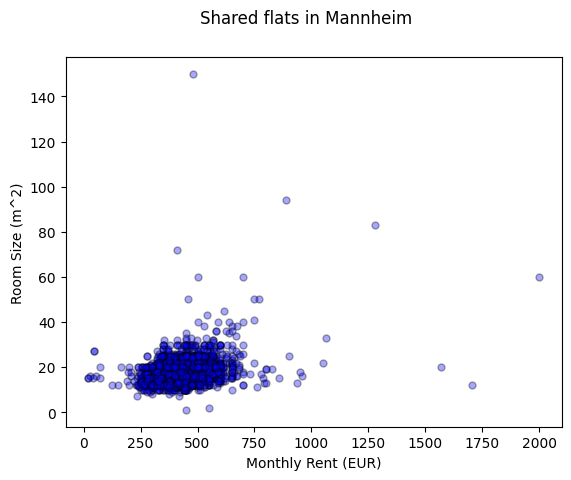

PearsonRResult(statistic=0.3102827513671921, pvalue=1.0663485819133261e-54)

In [153]:
plt.style.use('default')
fig, ax = plt.subplots()
fig.suptitle("Shared flats in Mannheim")
#ax.grid()
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Monthly Rent (EUR)')
plt.ylabel('Room Size (m^2)')
plt.scatter(rentPrice, roomSize, s=25, c='blue',edgecolors='black', linewidths=1, alpha=0.35)
plt.show()

scipy.stats.pearsonr(rentPrice, roomSize)


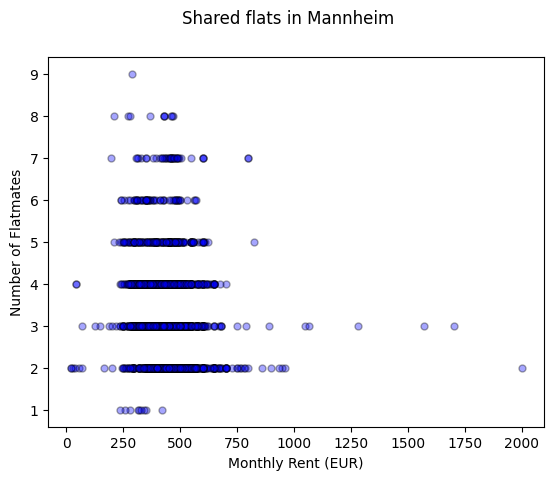

PearsonRResult(statistic=-0.12749535981667748, pvalue=3.680561665836592e-10)

In [154]:
plt.style.use('default')
fig, ax = plt.subplots()
fig.suptitle("Shared flats in Mannheim")
plt.xlabel('Monthly Rent (EUR)')
plt.ylabel('Number of Flatmates')
plt.scatter(rentPrice, flatmates, s=25, c='blue',edgecolors='black', linewidths=1, alpha=0.35)
plt.show()

scipy.stats.pearsonr(rentPrice, flatmates)

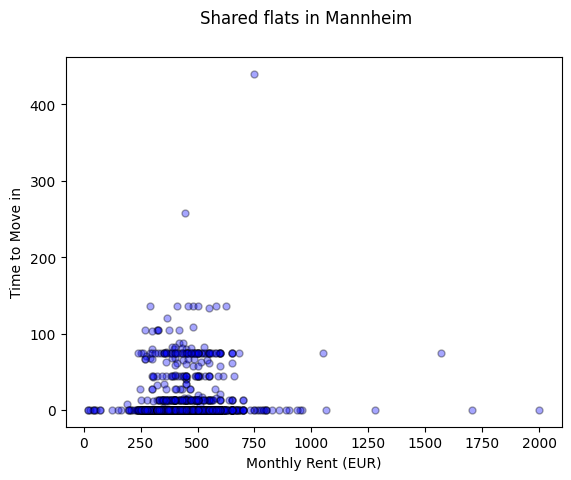

PearsonRResult(statistic=-0.12749535981667748, pvalue=3.680561665836592e-10)

In [155]:
plt.style.use('default')
fig, ax = plt.subplots()
fig.suptitle("Shared flats in Mannheim")
plt.xlabel('Monthly Rent (EUR)')
plt.ylabel('Time to Move in')
plt.scatter(rentPrice, timeToMoveIn, s=25, c='blue',edgecolors='black', linewidths=1, alpha=0.35)
plt.show()

scipy.stats.pearsonr(rentPrice, flatmates)